### Predicting Car Prices

#### Objective: Predict the car prices on features like brand, mileage, and condition.

#### Description

This program predicts the price for the used cars on features like brand, mileage, and condition of the car. 

Used car price prediction dataset is collection of automotive information collected from the popular website for 
datascience and machine learning practitioners [Kaggle](https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset/data). This dataset comprises 4,009 data points, each representing a unique vehicle listing, and includes nine distinct features providing valuable insights into the world of automobiles.

- Brand & Model: Identify the brand or company name along with the specific model of each vehicle.

- Model Year: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.

- Mileage: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.

- Fuel Type: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.

- Engine Type: Understand the engine specifications, shedding light on performance and efficiency.

- Transmission: Determine the transmission type, whether automatic, manual, or another variant.

- Exterior & Interior Colors: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.

- Accident History: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.

- Clean Title: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.

- Price: Access the listed prices for each vechile, aiding in price comparision and budgeting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv('used_cars.csv')


# Data Cleaning 

In [2]:
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64


In [3]:
df = df.dropna()
print(df.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64


In [4]:
df = df.rename(columns={'milage': 'mileage'})

In [5]:
text_columns = ['brand','model', 'fuel_type', 'transmission', 'ext_col', 'int_col']
for col in text_columns:
    df[col] = df[col].str.lower().str.strip()

def remove_non_numeric(value):
        if isinstance(value, str):
            return ''.join(filter(str.isdigit, value))
        return value

df['mileage'] = df['mileage'].apply(remove_non_numeric)
df['model_year'] = df['model_year'].apply(remove_non_numeric)
df['price'] = df['price'].apply(remove_non_numeric)


df['mileage'] = pd.to_numeric(df['mileage'])
df['model_year'] = pd.to_numeric(df['model_year'])
df['price'] = pd.to_numeric(df['price'])


In [6]:
df['model_year'] = df['model_year'].astype(int)
df['mileage'] = df['mileage'].astype(int)
df['price'] = df['price'].astype(float)

df.head()
df['clean_title'].unique()

array(['Yes'], dtype=object)

In [7]:
# Create binary variables
df['accident'] = df['accident'].map({'At least 1 accident or damage reported': 1, 'None reported': 0})
df['clean_title'] = df['clean_title'].map({'Yes': 1, 'No': 0})

In [8]:
# Print sample of cleaned data
print("\nSample of cleaned data:")
df.head()

# Print data info after cleaning

print("\nData info after cleaning:")
df.info()


Sample of cleaned data:

Data info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 3269 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         3269 non-null   object 
 1   model         3269 non-null   object 
 2   model_year    3269 non-null   int64  
 3   mileage       3269 non-null   int64  
 4   fuel_type     3269 non-null   object 
 5   engine        3269 non-null   object 
 6   transmission  3269 non-null   object 
 7   ext_col       3269 non-null   object 
 8   int_col       3269 non-null   object 
 9   accident      3269 non-null   int64  
 10  clean_title   3269 non-null   int64  
 11  price         3269 non-null   float64
dtypes: float64(1), int64(4), object(7)
memory usage: 332.0+ KB


# EDA

#### Checking for the outliers

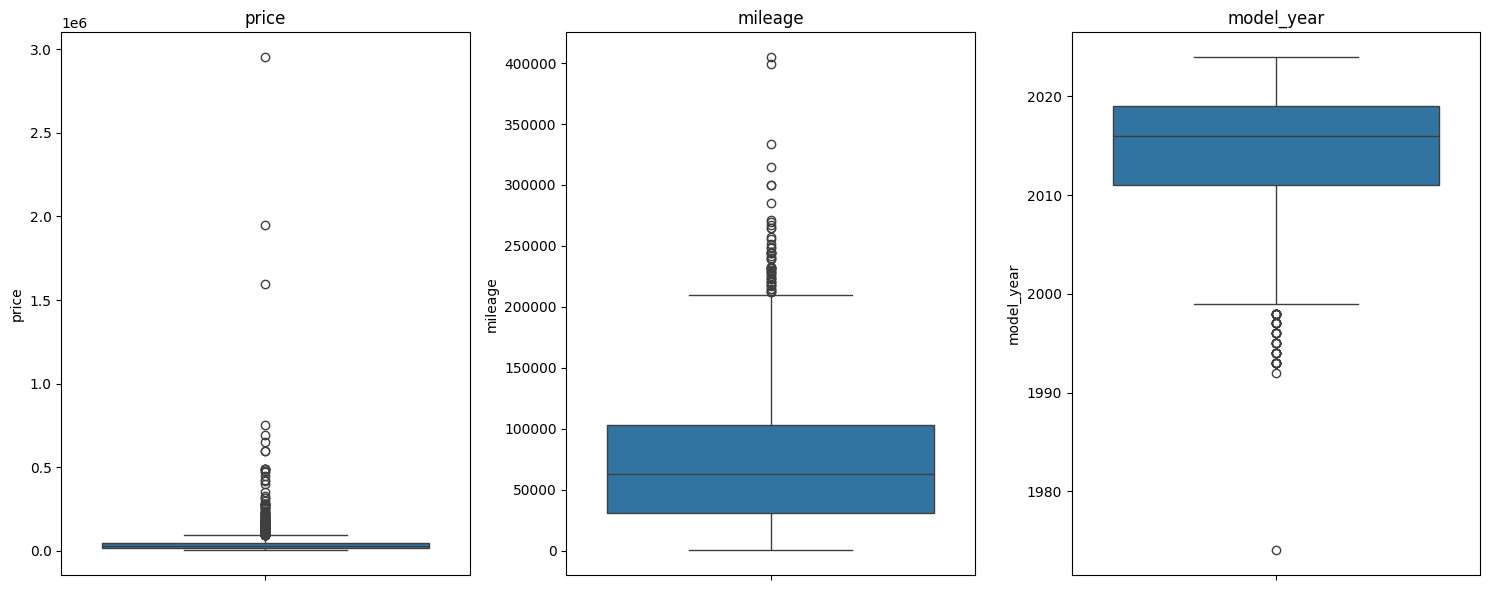

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,ford,utility police interceptor base,2013,51000,e85 flex fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-speed a/t,black,black,1,1,10300.0
1,hyundai,palisade sel,2021,34742,gasoline,3.8L V6 24V GDI DOHC,8-speed automatic,moonlight cloud,gray,1,1,38005.0
3,infiniti,q50 hybrid sport,2015,88900,hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-speed a/t,black,black,0,1,15500.0
6,audi,s3 2.0t premium plus,2017,84000,gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-speed a/t,blue,black,0,1,31000.0
7,bmw,740 il,2001,242000,gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,a/t,green,green,0,1,7300.0


In [9]:
# Checking for outliers

num_col = ['price', 'mileage', 'model_year']

plt.figure(figsize=(15, 6))
for i, col in enumerate(num_col, 1):
    plt.subplot(1, len(num_col), i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

df.head()

#### Removing outliers

In [10]:
# Handling outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'price')
df = remove_outliers(df, 'mileage')
df = remove_outliers(df, 'model_year')

## Feature Engineering

### a. Create age of the car from model year and investigate its effect on price

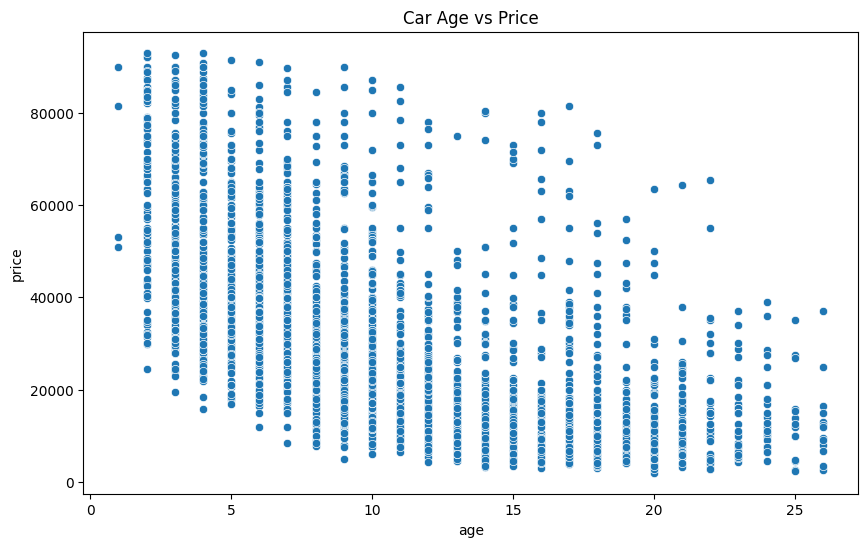

In [11]:
current_year = datetime.now().year
df['age'] = current_year - df['model_year']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='price', data=df)
plt.title('Car Age vs Price')
plt.show()


##### Here we can see the relationship between the age of the car and the price. The price of the car decreases as the age of the car increases.

### b. Generate interaction features like mileage/age ratio and analyze if they provide more predictive power and price.

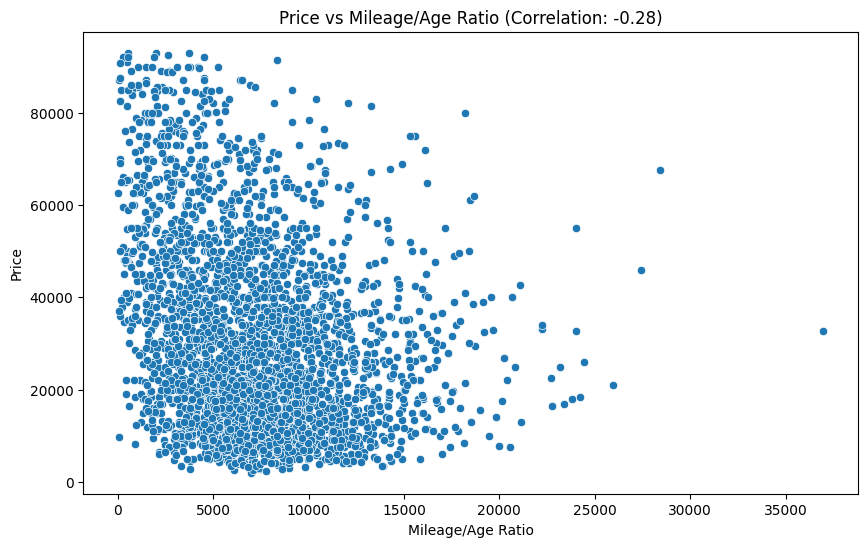

In [12]:
df['mileage_age_ratio'] = df['mileage'] / df['age']

correlation = df['price'].corr(df['mileage_age_ratio'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mileage_age_ratio', y='price', data=df)
plt.title(f'Price vs Mileage/Age Ratio (Correlation: {correlation:.2f})')
plt.xlabel('Mileage/Age Ratio')
plt.ylabel('Price')
plt.show()

##### Here with the correlation value of -0.39, we can see that there is a weak negative correlation between the price and the mileage/age ratio. This means that as the mileage/age ratio increases, the price of the car decreases.

## Price Distribution by Categories

### 1. Accident History and Clean Title
###     a. Investigate the difference in the price distributions for cars with accidents vs those without accidents

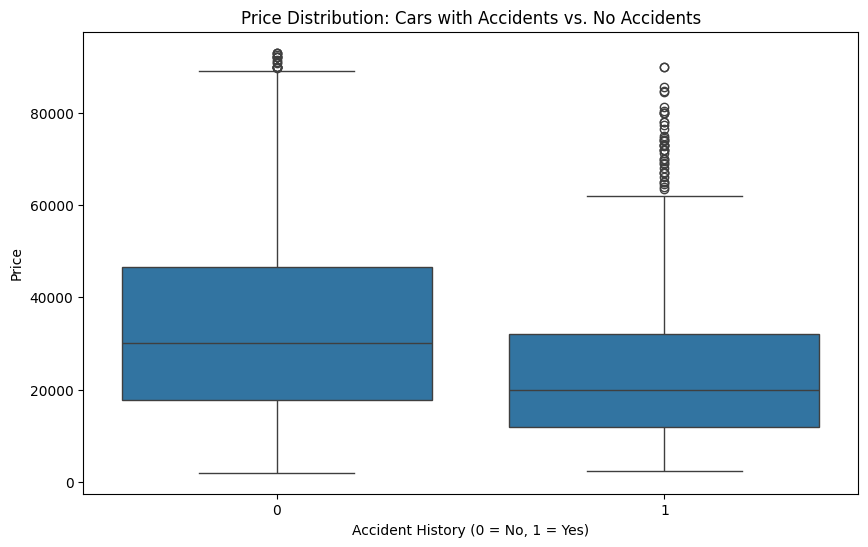

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accident', y='price', data=df)
plt.title('Price Distribution: Cars with Accidents vs. No Accidents')
plt.xlabel('Accident History (0 = No, 1 = Yes)')
plt.ylabel('Price')
plt.show()


##### Here we can see that cars with accidents have a lower price compared to cars with no accidents. This is expected as cars with accidents are generally considered to be of lower value compared to cars with no accidents.

### 2. Transmission, Engine Type and Fuel Type
### a. Counts plot to visualize how many cars from the changed transmission category are listed at higher points

['automatic' 'other' 'manual' 'cvt']


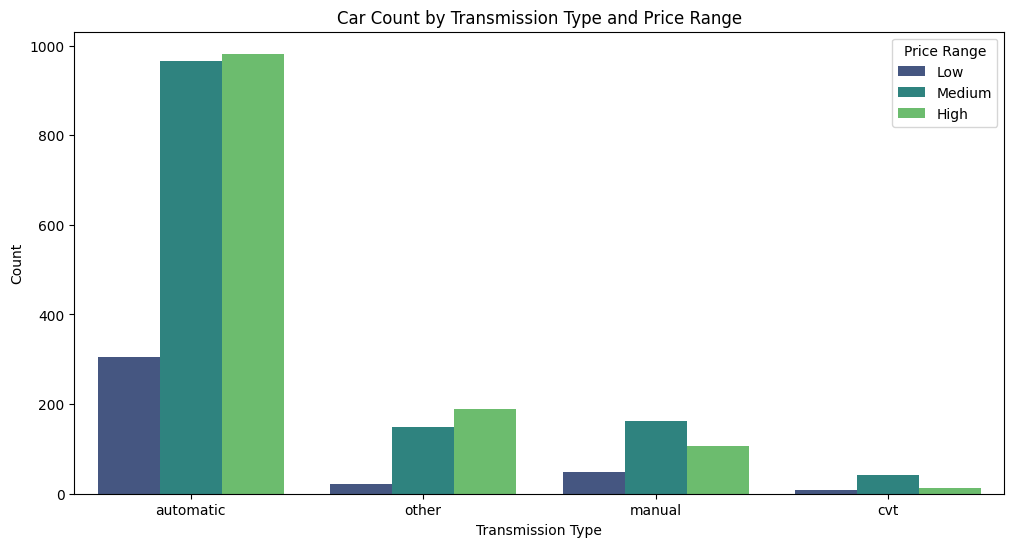

In [14]:
def standardize_transmission(trans):
    trans = str(trans).lower()
    if 'a/t' in trans or 'automatic' in trans:
        return 'automatic'
    elif 'm/t' in trans or 'manual' in trans:
        return 'manual'
    elif 'cvt' in trans:
        return 'cvt'
    else:
        return 'other'

# Assuming your DataFrame is named df
df['transmission'] = df['transmission'].apply(standardize_transmission)

# Print unique values to verify
print(df['transmission'].unique())


df['price_range'] = pd.cut(df['price'], bins=[0, 10000, 30000, float('inf')], labels=['Low', 'Medium', 'High'])

# Count plot for transmission categories
plt.figure(figsize=(12, 6))
sns.countplot(x='transmission', hue='price_range', data=df, palette='viridis')
plt.title('Car Count by Transmission Type and Price Range')
plt.xlabel('Transmission Type')
plt.ylabel('Count')
plt.legend(title='Price Range')
plt.show()

##### Here above we've created a count plot to show the distribution of car prices based on their transmission type. This shows that automatic cars are more expensive than manual cars, and that manual cars are more likely to be in the low price range.

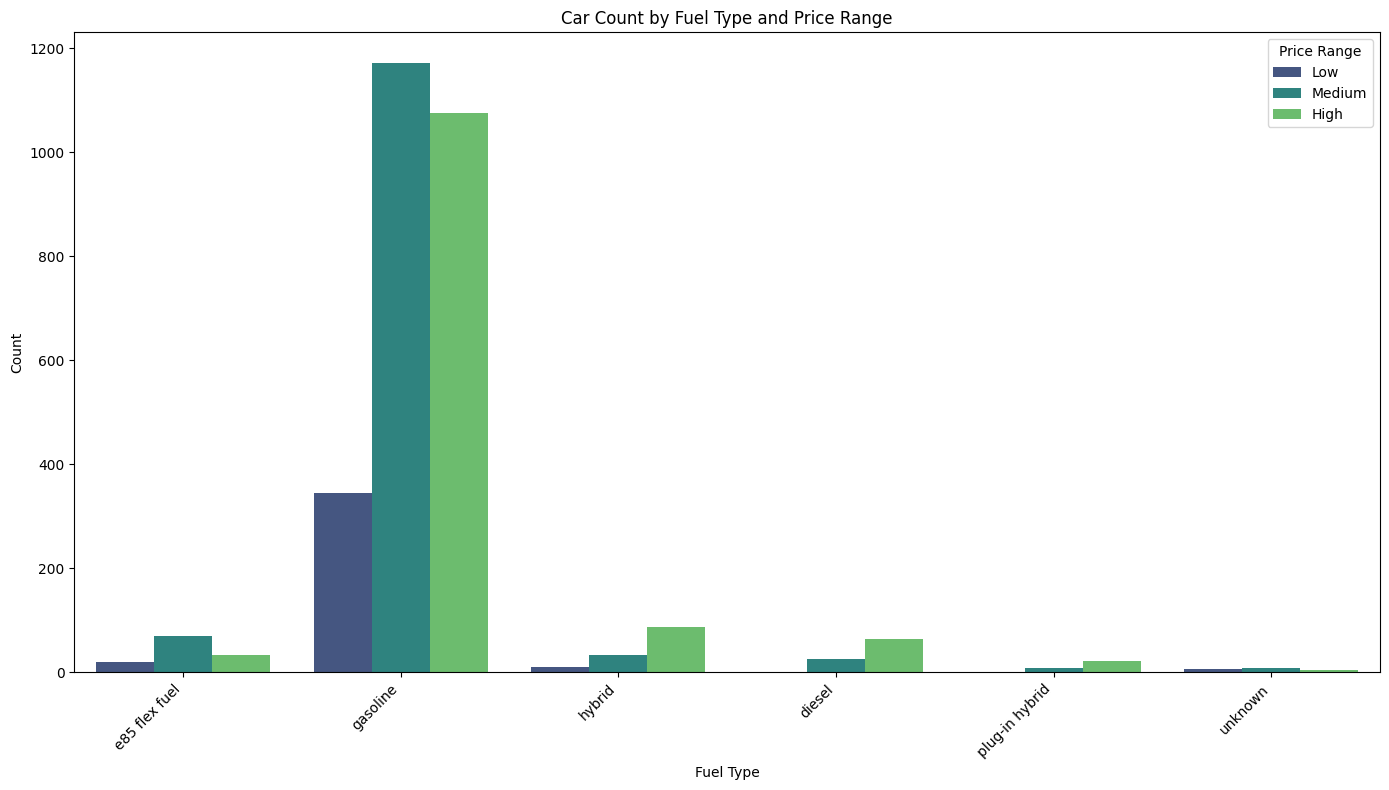

In [15]:
# For fuel

def standardize_fuel_type(fuel):
    if fuel in ['–', 'not supported']:
        return 'unknown'
    else:
        return fuel

df['fuel_type'] = df['fuel_type'].apply(standardize_fuel_type)

# Define price ranges
df['price_range'] = pd.cut(df['price'], bins=[0, 10000, 30000, float('inf')], labels=['Low', 'Medium', 'High'])

# Create count plot
plt.figure(figsize=(14, 8))
sns.countplot(x='fuel_type', hue='price_range', data=df, palette='viridis')
plt.title('Car Count by Fuel Type and Price Range')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.legend(title='Price Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Here the above one shows the count of cars based on the fuel type and price range. This tells us that most of the cars in the dataset are of medium price range and most of them are petrol cars.

## Model Year, Mileage, and Price relationship
### 1. Model Year Effect
### a. Create a facet grid with model year on one axis and price on the other, checking how the distribution of prices changes with age.

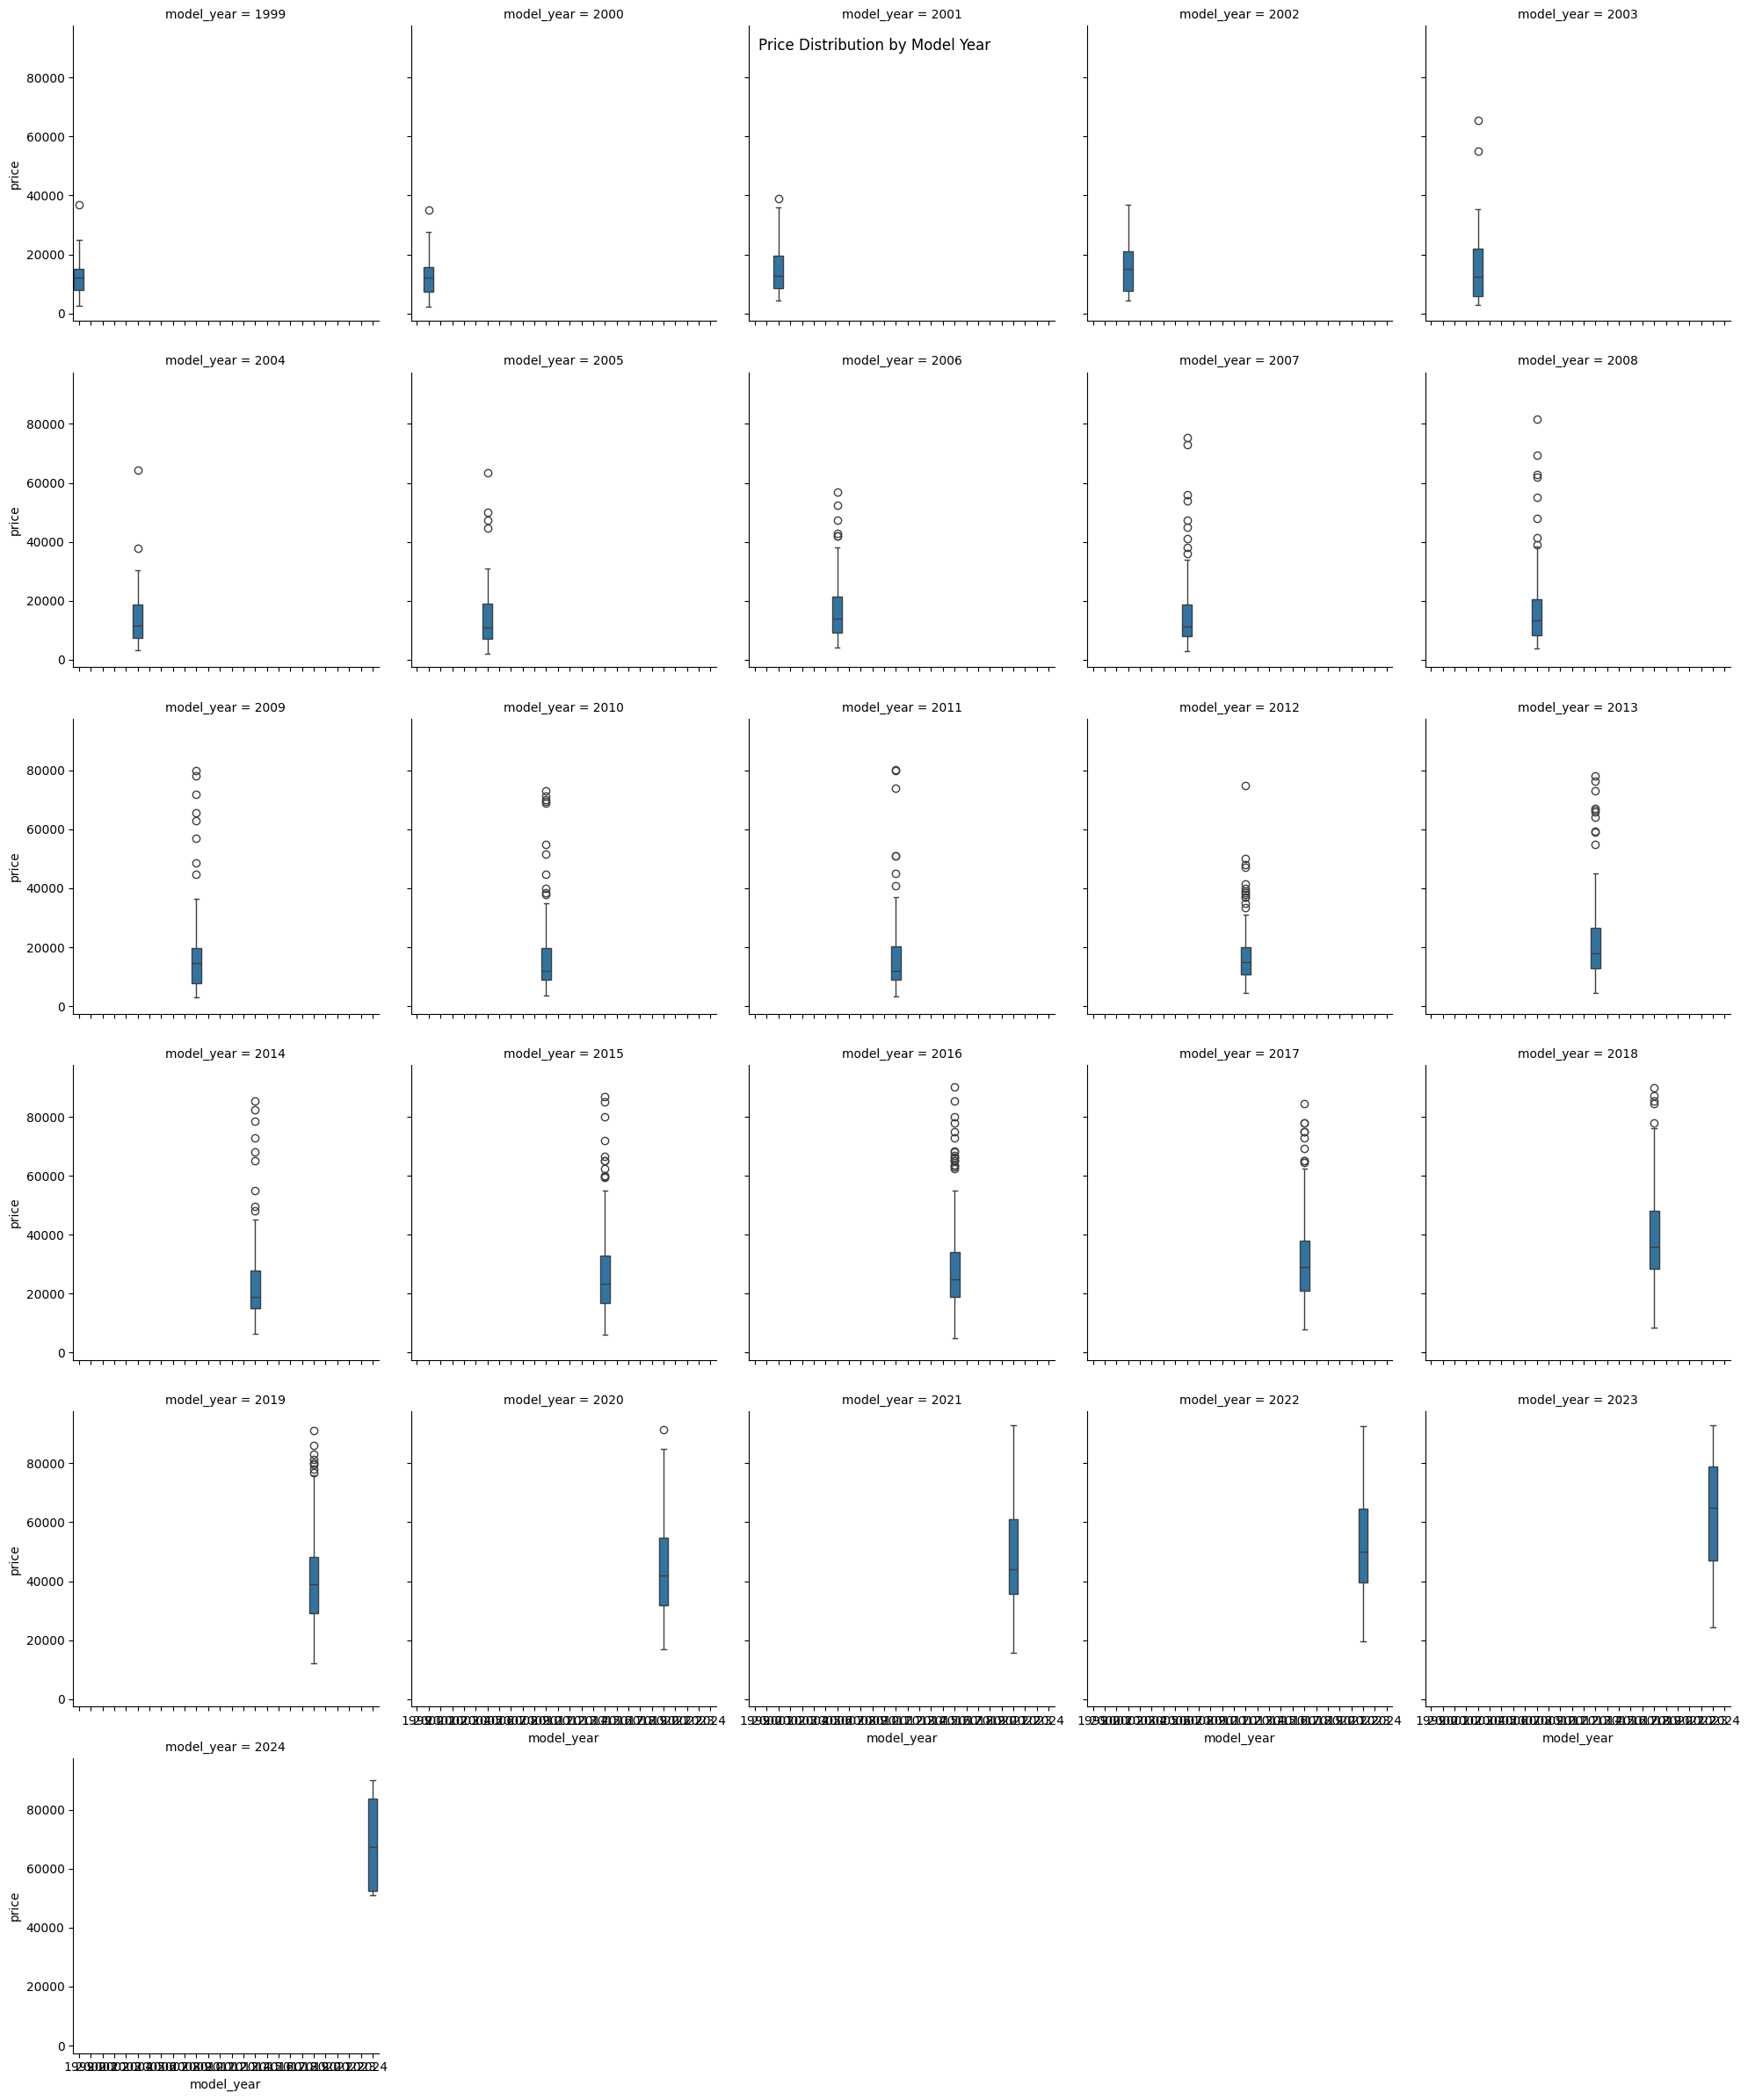

In [16]:

g = sns.FacetGrid(df, col='model_year', col_wrap=5, height=4)
g.map(sns.boxplot, 'model_year', 'price')
g.fig.suptitle('Price Distribution by Model Year')
plt.show()


##### Here we can see that the price of the cars is increasing with the model year. This tells us that the newer the car, the higher the price. This is a common trend in the used car market.

## Segmenation and Trend Analysis

###  Segment the cars into price ranges (e.g., budget, mid-range, luxury) and explorehow features like brand, model, and fuel type differ across these segments.

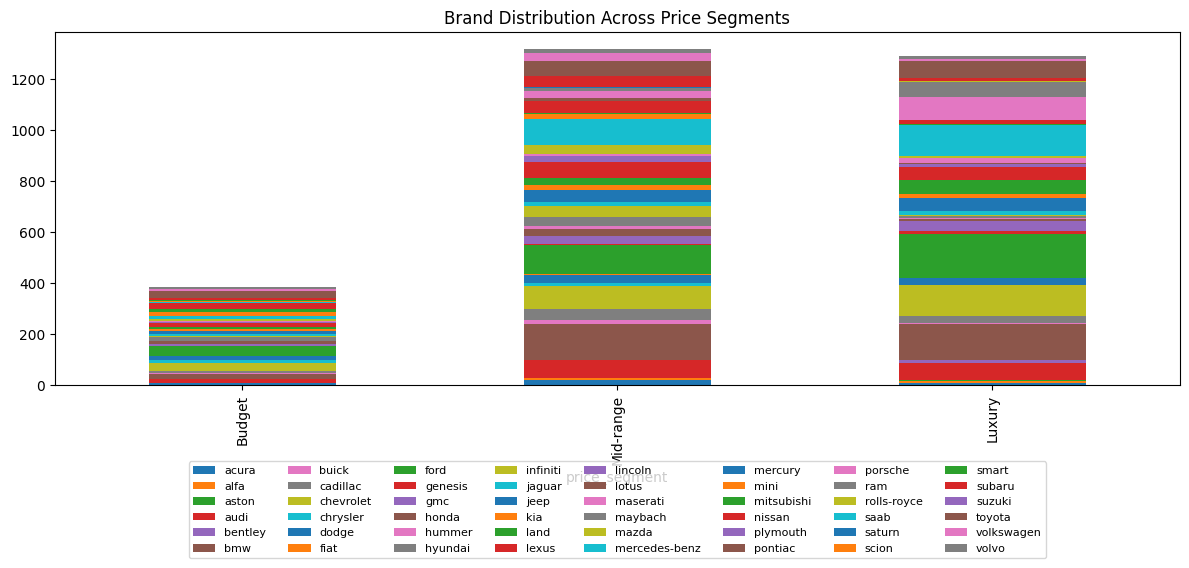

In [17]:
df['price_segment'] = pd.cut(df['price'], bins=[0, 10000, 30000, float('inf')], labels=['Budget', 'Mid-range', 'Luxury'])

brand_segment = df.groupby(['price_segment', 'brand']).size().unstack()
ax = brand_segment.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Brand Distribution Across Price Segments')

# Move Legend Below the Graph, Completely Outside
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=8, fontsize=8)  # Adjust ncol based on spacing

plt.tight_layout()  # Adjust layout so nothing gets cut off
plt.show()

##### Here we can see that the brand distribution is different across price segments. For example, the luxury segment has more BMW and Mercedes-Benz cars compared to the budget segment. This information can be useful for marketing and sales strategies.

In [18]:
# Step 1: Identify numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Step 2: Create a MinMaxScaler object
scaler = MinMaxScaler()

# Step 3: Apply Min-Max scaling to numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Print the first few rows to verify the scaling
print(df[numerical_columns].head())

# Optional: If you want to save the scaler for future use (e.g., for scaling new data)
import joblib
joblib.dump(scaler, 'minmax_scaler.joblib')

   model_year   mileage  accident  clean_title     price   age  \
0        0.56  0.240208       1.0          0.0  0.091209  0.44   
1        0.88  0.163483       1.0          0.0  0.395659  0.12   
3        0.64  0.419066       0.0          0.0  0.148352  0.36   
6        0.72  0.395941       0.0          0.0  0.318681  0.28   
8        0.88  0.110127       0.0          0.0  0.438758  0.12   

   mileage_age_ratio  
0           0.114195  
1           0.234316  
3           0.239854  
6           0.283456  
8           0.157770  


['minmax_scaler.joblib']

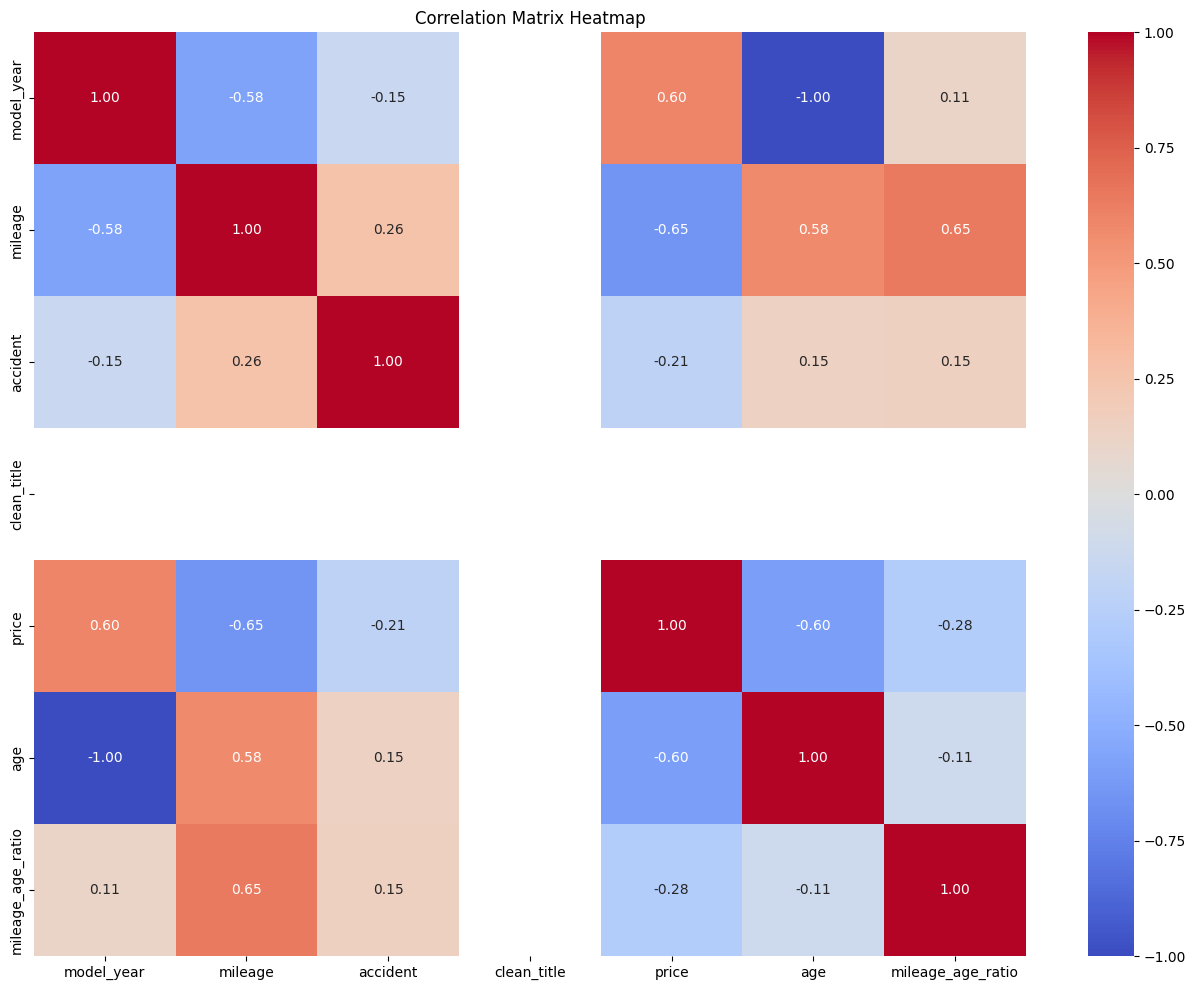

In [19]:
# Step 1: Encode categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Step 2: Select only numerical columns (including encoded categorical ones)
numerical_columns = df_encoded.select_dtypes(include=['number']).columns

# Step 3: Compute the correlation matrix
correlation_matrix = df_encoded[numerical_columns].corr()

# Step 4: Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

#####  From the above heatmap we can see that there are some columns which are highly correlated with each other. Now to predict the price using the Random Forest Regressor we need to select the features which are not highly correlated with the price.


In [20]:
df.head()


,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,age,mileage_age_ratio,price_range,price_segment
0,ford,utility police interceptor base,0.56,0.240208,e85 flex fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,automatic,black,black,1.0,0.0,0.091209,0.44,0.114195,Medium,Mid-range
1,hyundai,palisade sel,0.88,0.163483,gasoline,3.8L V6 24V GDI DOHC,automatic,moonlight cloud,gray,1.0,0.0,0.395659,0.12,0.234316,High,Luxury
3,infiniti,q50 hybrid sport,0.64,0.419066,hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,automatic,black,black,0.0,0.0,0.148352,0.36,0.239854,Medium,Mid-range
6,audi,s3 2.0t premium plus,0.72,0.395941,gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,automatic,blue,black,0.0,0.0,0.318681,0.28,0.283456,High,Luxury
8,lexus,rc 350 f sport,0.88,0.110127,gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,automatic,black,black,0.0,0.0,0.438758,0.12,0.157770,High,Luxury


In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 1: Identify the columns to encode
columns_to_encode = ['price_range', 'price_segment']

# Step 2: Create a ColumnTransformer with OneHotEncoder
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False), columns_to_encode)
], remainder='passthrough')

# Step 3: Fit and transform the data
encoded_array = ct.fit_transform(df)

# Step 4: Create a new DataFrame with encoded columns
encoded_columns = ct.named_transformers_['encoder'].get_feature_names_out(columns_to_encode)
all_columns = list(encoded_columns) + [col for col in df.columns if col not in columns_to_encode]

df_encoded = pd.DataFrame(encoded_array, columns=all_columns)

# Print the first few rows to verify the encoding
print(df_encoded.head())

# Optional: Save the ColumnTransformer for future use
import joblib
joblib.dump(ct, 'column_transformer.joblib')

  price_range_Low price_range_Medium price_segment_Luxury  \
0             0.0                1.0                  0.0   
1             0.0                0.0                  1.0   
2             0.0                1.0                  0.0   
3             0.0                0.0                  1.0   
4             0.0                0.0                  1.0   

  price_segment_Mid-range     brand                            model  \
0                     1.0      ford  utility police interceptor base   
1                     0.0   hyundai                     palisade sel   
2                     1.0  infiniti                 q50 hybrid sport   
3                     0.0      audi             s3 2.0t premium plus   
4                     0.0     lexus                   rc 350 f sport   

  model_year   mileage      fuel_type  \
0       0.56  0.240208  e85 flex fuel   
1       0.88  0.163483       gasoline   
2       0.64  0.419066         hybrid   
3       0.72  0.395941       gasolin

['column_transformer.joblib']

Training set size: 2393
Testing set size: 599

Model Evaluation on Test Set:
Mean Absolute Error (MAE): 0.08
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.12
R-squared (R²): 0.71

Feature Coefficients:
                   Feature   Coefficient
5     price_segment_Luxury  2.192094e-01
3          price_range_Low -1.807528e-01
0                      age -1.711057e-01
4       price_range_Medium -3.845662e-02
6  price_segment_Mid-range -3.845662e-02
1                 accident -1.340500e-02
2              clean_title -1.387779e-17


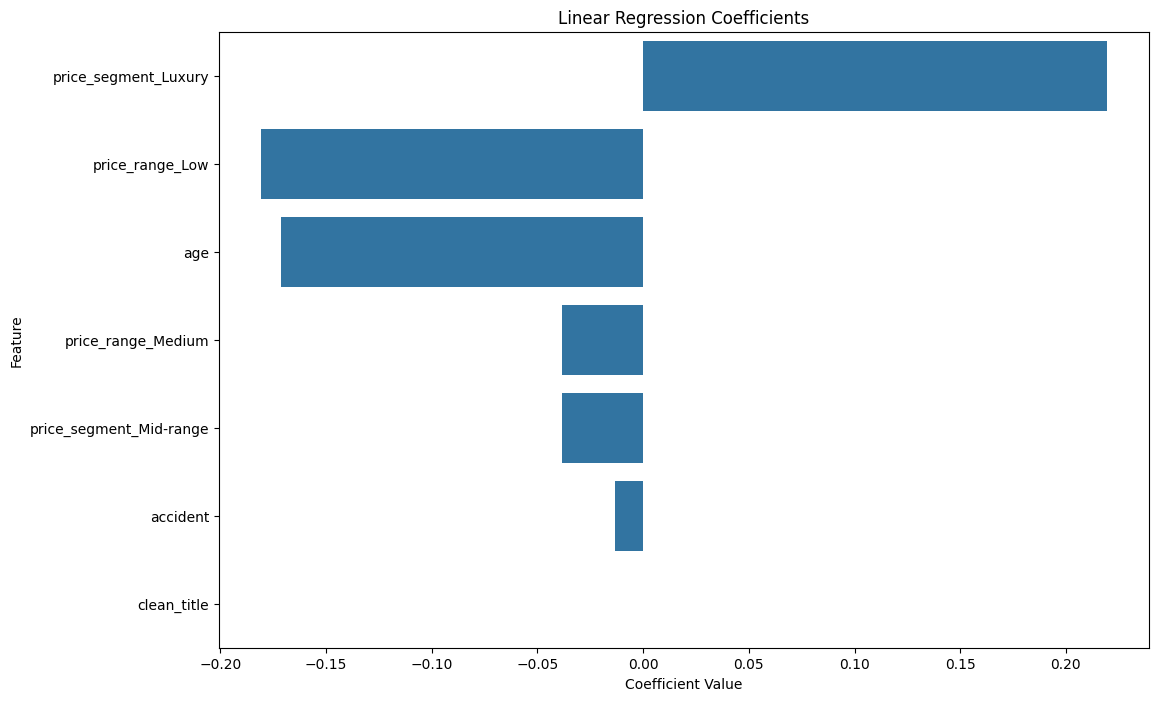

In [22]:
# Step 1: Select the features and target variable
features = ['age', 'accident', 'clean_title']  # Numerical features
encoded_columns = [col for col in df_encoded.columns if 'price_range_' in col or 'price_segment_' in col]
selected_features = features + encoded_columns  # Combine numerical and encoded categorical features

X = df_encoded[selected_features]  # Features
y = df_encoded['price']            # Target variable (price)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Step 3: Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 4: Evaluate the model on the testing set
y_pred_test = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"\nModel Evaluation on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Step 5: Visualize feature coefficients
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_
})
coefficients = coefficients.sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Coefficients:")
print(coefficients)

# Optional: Visualize feature coefficients using a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()